In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes('deep')

In [3]:
RANDOM_STATE = 112
N_MIXTURES_TO_SEARCH_FOR_EACH_K = 3
CPUS_TO_USE = 16
K_RANGE_TO_SEARCH = [2,3,4,5,6,7,8,9,10,11,12,13]
EPSILON = 1e-6 # difference to treat the log likelihood as converged

# Loading data

In [4]:
import sklearn.datasets
digits_dataset = sklearn.datasets.load_digits()
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index, name='label')

THRESHOLD = np.mean(digits.values.reshape(-1))
binary_digits = digits >= THRESHOLD

from sklearn.utils import shuffle
binary_digits = shuffle(binary_digits, random_state=RANDOM_STATE)
labels = labels.loc[binary_digits.index]

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [5]:
K=len(labels.unique())
D=len(binary_digits.columns)

In [6]:
def draw_digit(row, vmin=0, vmax=1, square=True, **kwargs):
    return sns.heatmap(row.astype(float).reshape(8, 8), square=square, vmin=vmin, vmax=vmax, **kwargs)

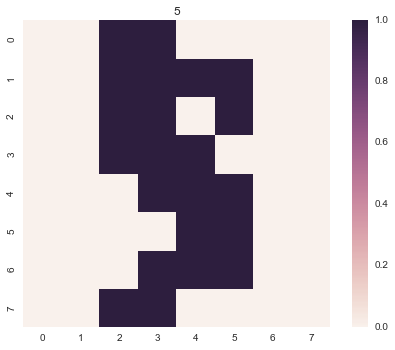

In [7]:
draw_digit(binary_digits.iloc[0])
plt.title(labels.iloc[0])

In [8]:
up_missing = binary_digits.iloc[:len(binary_digits)//4].copy()
bottom_missing = binary_digits.iloc[len(binary_digits)//4:len(binary_digits)//2].copy()
even_missing = binary_digits.iloc[len(binary_digits)//2:].copy()
up_missing.iloc[:, :D//2] = None
bottom_missing.iloc[:, D//2:] = None
even_missing.iloc[:, np.arange(0, D, 2)] = None

up_missing['dataset_id'] = 'up_missing'
bottom_missing['dataset_id'] = 'bottom_missing'
even_missing['dataset_id'] = 'even_missing'

training_data = pd.concat((up_missing, bottom_missing, even_missing))

In [9]:
training_data['weight'] = 1

In [10]:
def label_distribution(data, labels):
    ans = data[['dataset_id', 'weight']].join(labels).groupby(['dataset_id', 'label']).sum()['weight']
    ans /= ans.sum(level='dataset_id')
    
    return ans

# Part 1: Constrained coefficients for datasets

Lump the three datasets into one, call it 'merged' dataset

In [11]:
training_data_same_dataset = training_data.copy()
training_data_same_dataset['dataset_id'] = 'merged'

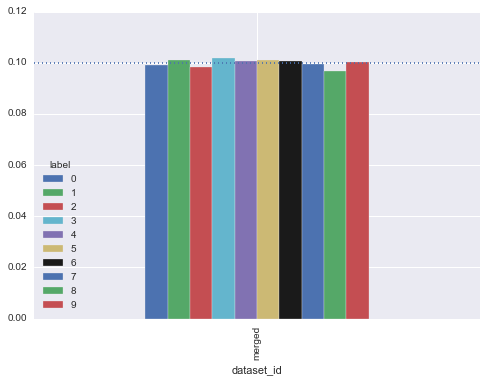

In [12]:
label_distribution(training_data_same_dataset, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [13]:
from bernoullimix.random_initialisation import random_mixture_generator

In [14]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

In [15]:
%%time
from bernoullimix.n_components_search import search_k

results, mixtures  = search_k(K_RANGE_TO_SEARCH, 
                              training_data_same_dataset, 
                              mixtures_per_k=N_MIXTURES_TO_SEARCH_FOR_EACH_K, 
                              random_state=RANDOM_STATE, 
                              n_jobs=CPUS_TO_USE, eps=EPSILON, n_iter=None)

CPU times: user 2.07 s, sys: 80 ms, total: 2.15 s
Wall time: 1min 58s


/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, 

Min BIC: 9


DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Iteration #1600. Likelihood -17789.69551445063: (diff: 1.91607978194952e-05)
DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Starting p:
          0         1         2         3         4         5         6   \
K0  0.510596  0.387215  0.698322  0.536606  0.262100  0.386258  0.929027   
K1  0.395331  0.135602  0.474135  0.525120  0.278605  0.859153  0.710213   

          7         8         9     ...           54        55        56  \
K0  0.187907  0.165818  0.021080    ...     0.294438  0.664594  0.263688   
K1  0.629410  0.269286  0.240692    ...     0.385583  0.337159  0.446976   

          57        58        59        60        61        62        63  
K0  0.113764  0.712182  0.366421  0.743770  0.549007  0.627644  0.374364  
K1  0.311160  0.831687  0.076068  0.238818  0.473481  0.319869  0.243087  

[2 rows x 64 columns]DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Iteration #100. Likelihood -20627.668751677127: (d

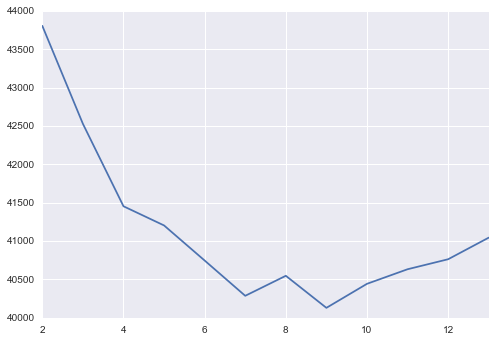

DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Iteration #1100. Likelihood -17502.85596323455: (diff: 0.0012353795536910184)
DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Iteration #1300. Likelihood -17447.195988000836: (diff: 1.2919044820591807e-06)
DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Starting p:
          0         1         2         3         4         5         6   \
K0  0.425032  0.470769  0.374770  0.287675  0.690997  0.290671  0.290208   
K1  0.529116  0.093846  0.365411  0.293223  0.677806  0.326942  0.205511   
K2  0.953638  0.713824  0.395617  0.927677  0.411302  0.672263  0.356271   
K3  0.257400  0.520635  0.799361  0.283542  0.143231  0.624957  0.228858   
K4  0.569250  0.626050  0.469434  0.540053  0.607530  0.163999  0.353803   
K5  0.647564  0.160889  0.565999  0.815049  0.474497  0.616326  0.859775   
K6  0.228284  0.273721  0.711209  0.662416  0.549754  0.544638  0.302416   
K7  0.463625  0.342093  0.276485  0.331144  0.355752  0.392585  0.

In [16]:
results['BIC'].plot()
best_k = results['BIC'].argmin()
print('Min BIC: {}'.format(best_k))

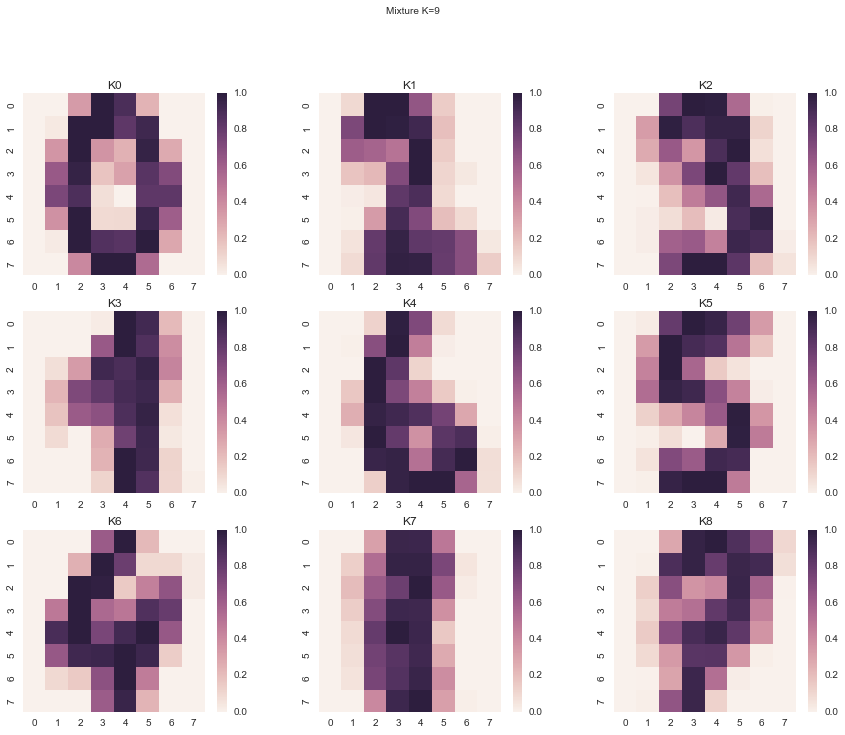

In [17]:
best_mixture = mixtures[best_k]
plt.figure(figsize=(15,15))
for j, (component, row) in enumerate(best_mixture.emission_probabilities.iterrows(), start=1):
    plt.subplot(4,3,j)
    draw_digit(row)
    plt.title(component)
plt.suptitle('Mixture K={}'.format(best_mixture.n_components))

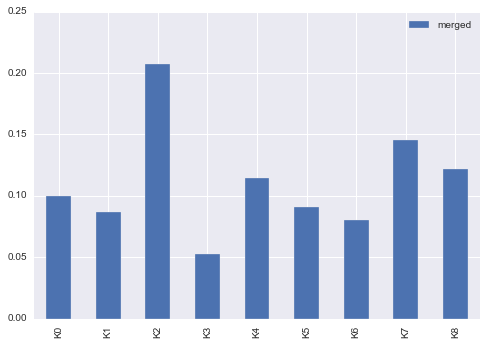

In [18]:
best_mixture.mixing_coefficients.T.plot(kind='bar')

# Part 2: Mixture constraint for each of the datasets

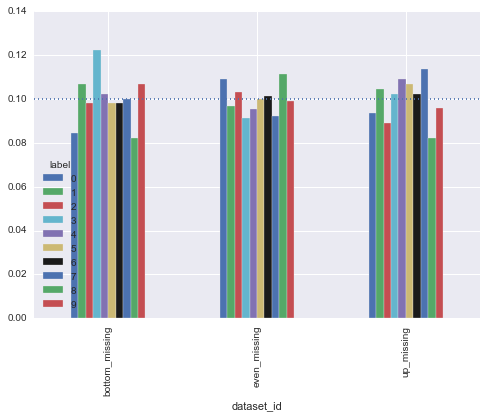

In [19]:
label_distribution(training_data, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [20]:
%%time
from bernoullimix.n_components_search import search_k

results_uc, mixtures_uc = search_k(K_RANGE_TO_SEARCH, 
                                   training_data, 
                                   mixtures_per_k=N_MIXTURES_TO_SEARCH_FOR_EACH_K, 
                                   random_state=RANDOM_STATE, 
                                   n_jobs=CPUS_TO_USE, eps=EPSILON, n_iter=None)

CPU times: user 2.2 s, sys: 107 ms, total: 2.31 s
Wall time: 46.3 s


/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]
/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, 

Min BIC: 6


DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Iteration #100. Likelihood -22762.730902105184: (diff: 1.8092367415119952)
DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Starting pi:
                 K0   K1   K2   K3   K4   K5   K6   K7   K8   K9
even_missing    0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
bottom_missing  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
up_missing      0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
DEBUG:bernoullimix.mixture.MultiDatasetMixtureModel:Starting p:
          0         1         2         3         4         5         6   \
K0  0.086707  0.578343  0.847008  0.394790  0.684881  0.742524  0.739849   
K1  0.190984  0.593501  0.528199  0.976120  0.292348  0.143980  0.226540   
K2  0.567863  0.343419  0.547797  0.931368  0.704994  0.493813  0.137297   
K3  0.743560  0.445569  0.484716  0.275923  0.789890  0.433295  0.047125   
K4  0.670245  0.010123  0.689734  0.412897  0.699845  0.799673  0.436461   
K5  0.723423  0.308838  0.53

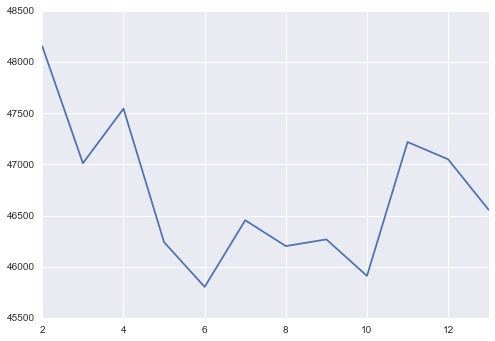

In [21]:
results_uc['BIC'].plot()
best_uc = results_uc['BIC'].argmin()
print('Min BIC: {}'.format(best_uc))

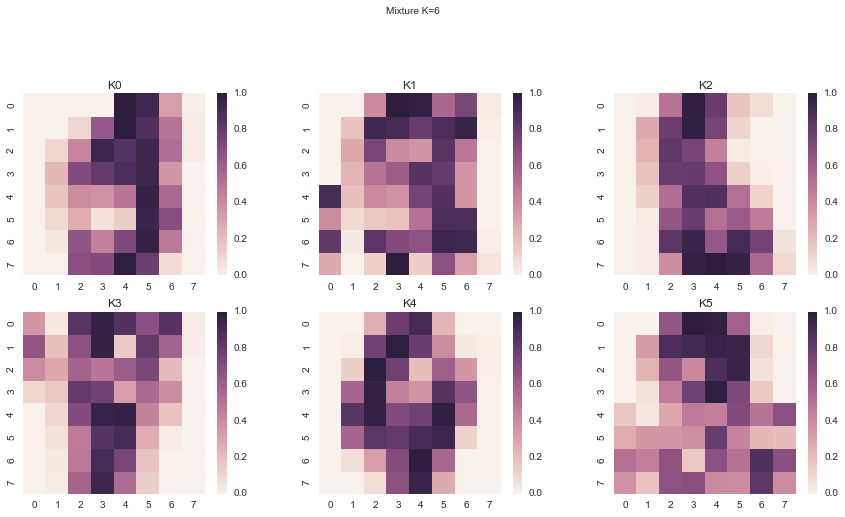

In [22]:
best_mixture_uc = mixtures_uc[best_uc]
plt.figure(figsize=(15,15))
for j, (component, row) in enumerate(best_mixture_uc.emission_probabilities.iterrows(), start=1):
    plt.subplot(4,3,j)
    draw_digit(row)
    plt.title(component)
plt.suptitle('Mixture K={}'.format(best_mixture_uc.n_components))

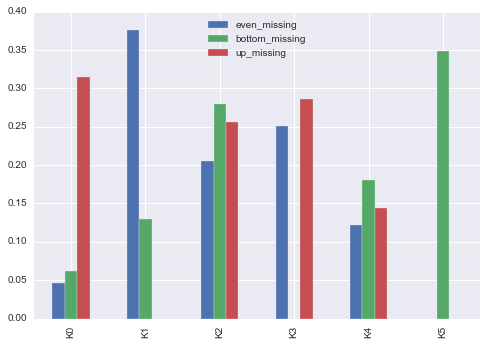

In [23]:
best_mixture_uc.mixing_coefficients.T.plot(kind='bar')